In [1]:
import numpy as np
import cv2
import os
from tqdm import tqdm
import numpy as np
from pathlib import Path
import sys
import matplotlib.pyplot as plt
sys.path.append('/home/ahmad/projects/utils/')
from custom_widgets import Browser

In [2]:
browser = Browser(parent_path='/data_sp/intercam/drd_behavior')
browser.show()

In [3]:
colormap = cv2.COLORMAP_TURBO
DEPTH_SCALE = 0.25

### read a frame - binary stop bit is determined based on the acquisition resolution via the set presest


In [4]:
# pick a random frame from the .dat
filepath = browser.path_textbox.value
if 'flir' in filepath.lower():
    preset = 'flir'
elif 'lucid' in filepath.lower():
    preset = 'lucid'
else:
    raise Exception("cannot understand preset from filename")
    
    
    ######################
    ## HELPER FUNCTIONS ##
    ######################

def readbinary(filepath, start=100, shape=None, preset=preset, pick_random=False):
    if preset is not None:
        if preset=='lucid':
            # multiply by 2 to accomodate the factt that we save distance data at 16bit
            shape = [640, 480]
            length = np.prod(shape) * 2
            dtype = np.uint16
        elif preset=='flir':
            shape = [720, 540]
            length= np.prod(shape)
            dtype = np.uint8
    else: 
        assert shape != None
        length = np.prod(shape)


    with open(filepath, 'rb') as file:
        file.seek(start*length)  # Move the pointer
        segment = file.read(length)  # Read the specfied length
    return segment, shape, dtype

def intensity_to_rgba(frame, minval=452, maxval=3065, colormap=cv2.COLORMAP_TURBO):
    new_frame = np.ones((frame.shape[0], frame.shape[1], 4))
    disp_frame = frame.copy().astype("float")
    disp_frame -= minval
    disp_frame[disp_frame < 0] = 0
    disp_frame /= np.abs(maxval - minval)
    disp_frame[disp_frame >= 1] = 1
    disp_frame *= 255
    bgr_frame = cv2.applyColorMap(disp_frame.astype(np.uint8), colormap)
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    new_frame[:, :, :3] = rgb_frame
    new_frame = new_frame.astype(np.uint8)
    return new_frame

def sort_rectangle_points(points):
    # Ensure the points are in a NumPy array
    points = np.array(points, dtype=np.float32)

    # Calculate the centroid of the points
    centroid = np.mean(points, axis=0)

    # Calculate the angles of each point relative to the centroid
    angles = np.arctan2(points[:,1] - centroid[1], points[:,0] - centroid[0])
    
    # Sort the points based on the angles
    sorted_indices = np.argsort(angles)
    
    return points[sorted_indices]
def crop_aligned_rectangle(image, points):
    # Ensure the points are in a NumPy array
    points = np.array(points, dtype=np.float32)

    # Find the bounding box of the points
    rect = cv2.boundingRect(points[:4])
    x, y, w, h = rect

    # Get the transformation matrix for the perspective transform
    dst_pts = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype=np.float32)
    M = cv2.getPerspectiveTransform(points, dst_pts)

    # Apply the perspective transformation to the image
    warped = cv2.warpPerspective(image, M, (w, h))

    return warped

def stack2mp4(rawfiledir, points, dims, fps=30, colormap=cv2.COLORMAP_INFERNO, minval=None, maxval=None):
    """
    Convert a sequence of images into an MP4 video.
    
    Args:
    - image_files (list): List of file paths to the input images.
    - output_video_path (str): Path to save the output video.
    - fps (int): Frames per second of the output video.
    """

    if preset == 'flir':
        minval=50
        maxval = 255
        dims = [720, 540]
        # dims = [360, 540]
        dtype = np.uint8
        length = np.prod(dims)

    if preset == 'lucid':
        minval = 900
        maxval=2300
        dims=[640, 480]
        dtype = np.uint16
        length = np.prod(dims) * 2

    stemname = Path(rawfiledir).stem
    output_dir = Path(rawfiledir).parent.joinpath(f'{stemname}_warped.avi').as_posix()
    
    # get first image
    print(f'determining dimensions')
    with open(filepath, 'rb') as file:
        file.seek(0)  # Move the pointer
        buffer = file.read(length)  # Read the specfied length
        buffer = np.frombuffer(buffer, dtype=dtype)
        # im3 is the frame reshaped to the correct shape
        buffer = buffer.reshape(dims[::-1])

        tempx = buffer
        tempx = crop_aligned_rectangle(tempx, points)
        dimx = tempx.shape
        cropped_dims = dimx[:2][::-1]
        print(f'cropped dimensions: {cropped_dims}')
        # Move the cursor to the end of the file
        file.seek(0, os.SEEK_END)
        file_size = file.tell()
        approx_num_frames = file_size//length
        
    print(f'saving to {output_dir}')
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_dir, fourcc, fps, cropped_dims, isColor=True)

    with open(filepath, 'rb') as file:
        try:
            for i in tqdm (range(approx_num_frames)):
                file.seek(i*length)
                buffer = file.read(length)  # Read the specfied length
                buffer = np.frombuffer(buffer, dtype=dtype)
                # im3 is the frame reshaped to the correct shape
                buffer = buffer.reshape(dims[::-1])
                img = intensity_to_rgba(buffer, minval=minval, maxval=maxval, colormap=colormap)[:,:,:3]
                img = crop_aligned_rectangle(img[..., [2, 1, 0]], points)
                # img = intensity_to_rgba(img, minval=img.min(), maxval=img.max(), colormap=colormap)[:,:,:3] 
                out.write(img)

        except Exception as e:
            print(e)
            out.release()


def create_binary_mask(image_shape, points):
    """
    Creates a binary mask with a polygon defined by the given points.
    
    Parameters:
    - image_shape: tuple, the shape of the output image (height, width)
    - points: list of tuples, the coordinates of the polygon vertices
    
    Returns:
    - mask: np.ndarray, the binary mask with dtype uint16
    """
    # Create an empty black image with dtype uint16
    mask = np.zeros(image_shape, dtype=np.uint16)
    
    # Convert points to the format required by fillPoly
    points = np.array(points, dtype=np.int32)
    points = points.reshape((-1, 1, 2))
    
    # Fill the polygon with 1 (since the mask is uint16, this is fine)
    cv2.fillPoly(mask, [points], 1)
    
    return mask


In [5]:
# im is the binary data of the first frame, read based on the preset (flir or lucid) acquisition resolution
im, shape, dtype = readbinary(filepath)
# im2 is the frame in the correct dtype
im2 = np.frombuffer(im, dtype=dtype)
# im3 is the frame reshaped to the correct shape
im3 = im2.reshape(shape[::-1])
im3 = im3 * DEPTH_SCALE

##############################
# ignore - for interactivity #
##############################
if preset == 'lucid':
    slider_values = {'minval': 300, 'maxval': 900}
else:
    slider_values = {'minval': 0, 'maxval': 115}
def display_frame(minval, maxval, colormap=cv2.COLORMAP_TURBO):
    bar = im3
    slider_values['minval'] = minval
    slider_values['maxval'] = maxval
    foo = intensity_to_rgba(bar, minval=minval, maxval=maxval, colormap=colormap)
    plt.imshow(foo[:,:,:3])
    plt.show()


### view frame - according to set colormap - set the min and max values

In [6]:
%matplotlib widget
plt.close('all')

from ipywidgets import interactive
frame_plot = interactive(display_frame, minval=slider_values['minval'], maxval=slider_values['maxval'], colormap=colormap)
output = frame_plot.children[-1]
output.layout.height = '450px'
frame_plot

interactive(children=(IntSlider(value=300, description='minval', max=900, min=-300), IntSlider(value=900, desc…

### cropping: select 4 points to warp and crop

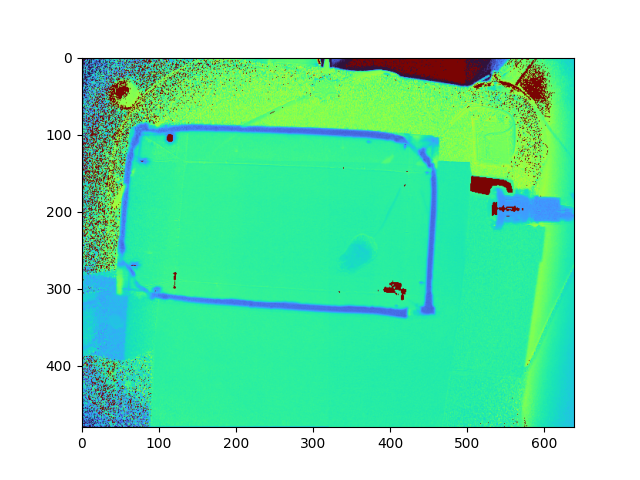

reached the limit of 4 points - restart the cell if you've made a mistake
reached the limit of 4 points - restart the cell if you've made a mistake
reached the limit of 4 points - restart the cell if you've made a mistake
reached the limit of 4 points - restart the cell if you've made a mistake


In [105]:
%matplotlib widget
im4 = intensity_to_rgba(im3, minval = slider_values['minval'], maxval=slider_values['maxval'], colormap=colormap)[:,:,:3]
fig, ax = plt.subplots()
ax.imshow(im4)
points = []

def onclick(event):
    if len(points) == 4:
        print('reached the limit of 4 points - restart the cell if you\'ve made a mistake')
        return
    if event.inaxes:
        x, y = event.xdata, event.ydata
        points.append((x, y))
        ax.plot(x, y, 'ro')
        fig.canvas.draw()

cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()



### show

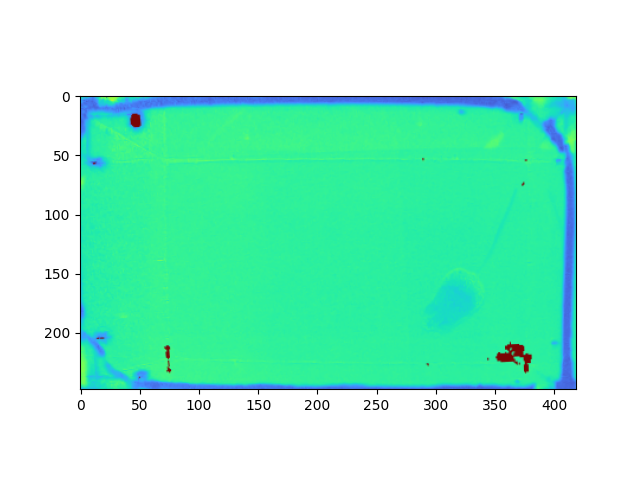

In [106]:
sorted_points = sort_rectangle_points(np.array(points))
warped_cropped = crop_aligned_rectangle(im4, points = sorted_points)

plt.figure()
plt.imshow(warped_cropped, cmap='turbo')
plt.show()

In [20]:
# isolate the pixels contained within the 4 points in points and put them in a 1d array
mask = create_binary_mask(im3.shape, points)
masked = im3[mask == 1]

In [107]:
def remove_artifacts(frame, max_value, floor_value):
    frame = frame.copy()
    frame_mask = frame > max_value
    frame_mask = frame_mask.astype(np.uint16)
    frame[frame_mask==1] = floor_value
    return frame



In [110]:
def make_test_dataset(filepath, points, start, end, frame_size=[640, 480], depth_scale=DEPTH_SCALE):
    for f, i in enumerate(range(start, end)):
        im, shape, dtype = readbinary(filepath, start=i, shape=frame_size[::-1])
        im2 = np.frombuffer(im, dtype=dtype)
        # im3 is the frame reshaped to the correct shape
        im3 = im2.reshape(shape[::-1]).astype(dtype)
        im3 = im3 * depth_scale
        im4 = crop_aligned_rectangle(im3, points)
        if f == 0:
            frames = np.zeros([end-start, *im4.shape], dtype=dtype)

        # mask = create_binary_mask(shape[::-1], points)
        # im4 = np.multiply(im3, mask )
        # masked = im4[mask == 1]
        floor_value = np.median(im4)
        added_margin = np.abs(masked.mean() - floor_value)
        if f == 0:
            print(floor_value, added_margin)
        max_value = floor_value + added_margin
        im4 = remove_artifacts(im4, max_value=max_value, floor_value=floor_value)
        
        frames[f] = im4
    return np.array(frames, dtype=dtype)


In [ ]:
import yaml

In [114]:
frames = make_test_dataset(filepath=filepath, points=points, start=1000, end=3000)

522.310546875 63.00463360476044


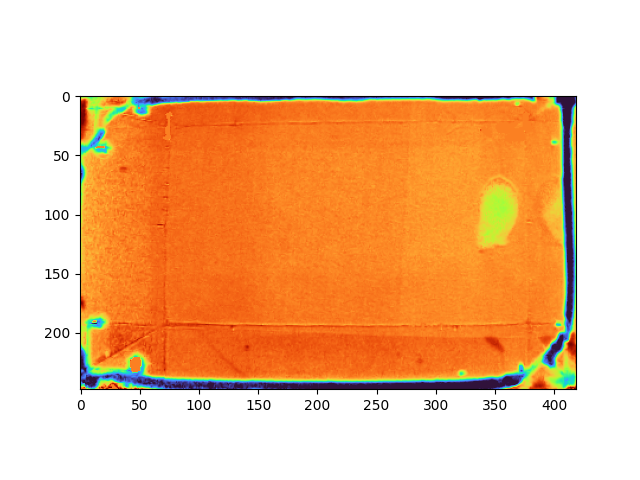

In [123]:
plt.cla()
plt.imshow(frames[600], vmin=380, vmax=570, cmap='turbo')
plt.show()

In [125]:
fp = Path(filepath)
output_dir = fp.parent.joinpath(f'{fp.stem}_warped.depth').as_posix()
with open(output_dir, 'w') as file:
    frames.tofile(file)

In [126]:
frames.shape

(2000, 248, 419)

In [86]:
means = []

for f in frames:
    x = f[f>0]
    means.append(x.mean())


In [93]:
from scipy.signal import convolve
# import gaussian window
from scipy.ndimage import gaussian_filter1d


def smooth(x, window_len=11, window='hanning'):
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len < 3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    s = np.r_[x[window_len-1:0:-1], x, x[-2:-window_len-1:-1]]
    if window == 'flat': #moving average
        w = np.ones(window_len,'d')
    else:
        w = eval('np.' + window + '(window_len)')
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y

In [103]:
y = smooth(np.array(means), window_len=30, window='blackman')
y-= 480